## Import libraries

In [1]:
## Import libraries
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin'
sys.path.append('/Users/riccardo/Documents/GitHub/COVID19Classification/')

from Modules import Parameters, DataPreprocessing as DP, Classification as CL, CustomFunctions as CF

3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 17:50:39) 
[GCC Clang 10.0.0 ]


## Parameters

In [2]:
## Multivariate sets
immunecells_set = Parameters.immunecells_set
FC_set = Parameters.FC_set
Dem_set = Parameters.Dem_set
CK_set = Parameters.CK_set
BM_set =  Parameters.BM_set
allinput_set = Parameters.allinput_set
## Targets
target_train = Parameters.train_target
target_test = Parameters.test_target

## Age
lower_bound = Parameters.age_min
upper_bound = Parameters.age_max

## Delta onset
lower_bound_donset = Parameters.donset_min
upper_bound_donset = Parameters.donset_max

## Minimum NPV
min_NPV_Models = Parameters.min_NPV_Models
min_NPV = Parameters.min_NPV

## Correlation threshod
corr_th_univ = Parameters.corr_th_univ

## Min % no nans per column
perc_nonans = Parameters.perc_nonans
perc_nonans_univ = Parameters.perc_nonans_univ

## Nan masking row-wise
do_nan_masking = Parameters.do_nan_masking
do_nan_masking_univ = Parameters.do_nan_masking_univ
nan_masking = Parameters.nan_masking
do_nan_masking_groupwise = False #Parameters.do_nan_masking_groupwise

## Reference time
ref_time = Parameters.ref_time

## N samples for average
N_av = Parameters.N_av

## Imputation
imputation_method = Parameters.imputation_method
imputation_method_univ = Parameters.imputation_method_univ

## Standardization
std_method = Parameters.std_method

## PCA % var. threshold
pc_var_th = Parameters.pca_var_threshold

## Preprocessing
do_preprocessing = Parameters.do_preprocessing_univ

## Train-test
test_size = Parameters.test_size

## Plot
plot_minNPV_models = Parameters.plot_minNPV_models

## Feature selection
use_manual_selection = Parameters.use_manual_selection

## Paths
path_datasets = Parameters.path_datasets
path_results = Parameters.path_results
path_figures = Parameters.path_figures
exp_description = Parameters.exp_description
exp_univ_description = Parameters.exp_univ_description
exp_multiv_description = Parameters.exp_multiv_description
foldername_univ = Parameters.foldername_univ
foldername_multiv = Parameters.foldername_multiv

## Dataset
use_CCIMasked_dataset = Parameters.use_CCIMasked_dataset

## Regulariser
find_regulariser_before_average = Parameters.find_regulariser_before_average

## Run experiments
run_experiments = True

## Import and prepare datasets

In [3]:
DataInpatients, DataOutpatients = DP.data_preprocessing()

# Mask data by target
mask = pd.notnull(DataInpatients[target_train].values) & pd.notnull(DataInpatients[target_test].values)
DataInpatients = DataInpatients.loc[mask,:]

Original shape inpatients data: (826, 94)
Original shape outpatients data: (462, 98)


## Models dictionary

In [4]:
models_dict = {}

## LR models
models_dict['LR'] = {}
for variable in allinput_set:
    models_dict['LR'][variable] = [variable]

### Run analysis - multiple splits

In [5]:
if run_experiments:
    Data = DataInpatients.copy()     
    
    ## Initialize results dictionaries
    Results_N_av = {}
    Ground_Truth_N_av = {}
    for model in models_dict.keys():
        Results_N_av[model] = {}
        Ground_Truth_N_av[model] = {}
        for set_name in models_dict[model].keys():
            Results_N_av[model][set_name] = {'Train':[], 'Test':[], 'Train_value': [], 'Test_value': [], 'Weights':[], 'Bias':[], 'C':[], 'Std_Parameters': []}
            Ground_Truth_N_av[model][set_name] = {'Train':[], 'Test':[]}
            if min_NPV_Models:
                Results_N_av[model][set_name+'_minNPV'] = {'Train':[], 'Test':[], 'Train_value': [], 'Test_value': [], 'Cutoff': []}
                Ground_Truth_N_av[model][set_name+'_minNPV'] = {'Train':[], 'Test':[]}
    
    do_statistic_misclassified = True
    if do_statistic_misclassified:
        positives = Data.loc[Data[target_test].values==1, 'ID'].values
        negatives = Data.loc[Data[target_test].values==0, 'ID'].values
        Negatives_N_av = {}
        False_positives_N_av = {}
        Positives_N_av = {}
        False_negatives_N_av = {}
        for model in models_dict.keys():
            model_set_names = models_dict[model].keys()
            Negatives_N_av[model] = pd.DataFrame(np.zeros((len(negatives), len(model_set_names))), index=negatives, columns=model_set_names)
            False_positives_N_av[model]= pd.DataFrame(np.zeros((len(negatives), len(model_set_names))), index=negatives, columns=model_set_names)
            Positives_N_av[model] = pd.DataFrame(np.zeros((len(positives), len(model_set_names))), index=positives, columns=model_set_names)
            False_negatives_N_av[model] = pd.DataFrame(np.zeros((len(positives), len(model_set_names))), index=positives, columns=model_set_names)
            

    ## Sets of variables for nan removal
    groups = [FC_set, CK_set, Dem_set, BM_set]


    ## Run average
    fix_outliers = False
    do_imputation = False
    print('Running average...')
    print('Fix outliers: %s' % fix_outliers)
    print('Do imputation: %s' % do_imputation)
    print('Nan masking groupwise: %s' % do_nan_masking_groupwise)
    for i_split in range(N_av): 
        print('%d/%d' %(i_split+1, N_av))
        
        Results = CL.models_prediction(Data=Data.copy(),
                                       test_size=test_size,
                                       models_dict=models_dict,
                                       target_train=target_train, 
                                       target_test=target_test, 
                                       min_NPV=min_NPV,
                                       min_NPV_Models=min_NPV_Models,
                                       standardization=std_method, 
                                       imputation=imputation_method, 
                                       do_nan_masking=do_nan_masking,
                                       do_nan_masking_univ=do_nan_masking_univ,
                                       nan_masking=nan_masking, 
                                       do_nan_masking_groupwise=do_nan_masking_groupwise, 
                                       groups=groups,
                                       do_preprocessing=do_preprocessing, 
                                       fix_outliers=fix_outliers,
                                       do_imputation=do_imputation)

        for model in Results_N_av.keys():
            for set_name in Results_N_av[model].keys():
                Ground_Truth_N_av[model][set_name]['Train'].append(Results[model][set_name]['Train_Labels'])
                Ground_Truth_N_av[model][set_name]['Test'].append(Results[model][set_name]['Test_Labels'])
                Results_N_av[model][set_name]['Train_value'].append(Results[model][set_name]['Train_value'])
                Results_N_av[model][set_name]['Test_value'].append(Results[model][set_name]['Test_value'])
                Results_N_av[model][set_name]['Train'].append(Results[model][set_name]['Train'])
                Results_N_av[model][set_name]['Test'].append(Results[model][set_name]['Test'])
                
                if model=='LR' and 'minNPV' in set_name:
                    Results_N_av[model][set_name]['Cutoff'].append(Results[model][set_name]['Cutoff'])

                if model=='LR' and '_minNPV' not in set_name:
                    Results_N_av[model][set_name]['Weights'].append(Results[model][set_name]['Weights'])
                    Results_N_av[model][set_name]['Bias'].append(Results[model][set_name]['Bias'])
                    Results_N_av[model][set_name]['C'].append(Results[model][set_name]['C'])
                    Results_N_av[model][set_name]['Std_Parameters'].append(Results[model][set_name]['Std_Parameters'])
                        
                if do_statistic_misclassified and '_minNPV' not in set_name:
                    ID_test = Results[model][set_name]['ID_test']
                    labels_test = Results[model][set_name]['Test_Labels']
                    pred_test = Results[model][set_name]['Test']
                    
                    mask_positives = labels_test==1
                    ID_positives = ID_test[mask_positives]
                    Positives_N_av[model].loc[ID_positives, [set_name]] +=1
                    mask_false_negatives = mask_positives & (pred_test==0)
                    ID_false_negatives = ID_test[mask_false_negatives]
                    False_negatives_N_av[model].loc[ID_false_negatives, [set_name]] +=1

                    mask_negatives = labels_test==0
                    ID_negatives = ID_test[mask_negatives]
                    Negatives_N_av[model].loc[ID_negatives, [set_name]] +=1
                    mask_false_positives = mask_negatives & (pred_test==1)
                    ID_false_positives = ID_test[mask_false_positives]
                    False_positives_N_av[model].loc[ID_false_positives, [set_name]] +=1

Running average...
Fix outliers: False
Do imputation: False
Nan masking groupwise: False
1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100


### Parameters dictionary

In [6]:
if run_experiments:
    coefficients_dict = {}

    if 'LR' in Results_N_av.keys():
        for set_name in Results_N_av['LR'].keys():
            if '_minNPV' not in set_name:
                weights = np.array(Results_N_av['LR'][set_name]['Weights']).reshape(-1,)
                bias = np.array(Results_N_av['LR'][set_name]['Bias']).reshape(-1,)
                C_reg = np.array(Results_N_av['LR'][set_name]['C']).reshape(-1,)
                Std_Parameters = np.array(Results_N_av['LR'][set_name]['Std_Parameters']).reshape(-1,)

                coefficients_dict[set_name] = weights
                
coefficients_df = pd.DataFrame.from_dict(coefficients_dict)

### Compute performanes

In [7]:
if run_experiments:

    Performances = {}

    Scores = {'roc_auc_score': roc_auc_score,
              'f1': f1_score,
              'recall': recall_score,
              'precision': precision_score,
              'NPV': precision_score,
              'specificity': recall_score,
              'accuracy': accuracy_score}

    for model in Results_N_av.keys():
        Performances[model] = {}

        for set_name in Results_N_av[model].keys():
            #print(model, set_name)
            Performances[model][set_name] = {}
            print(model, set_name)

            for score in Scores.keys():
                Performances[model][set_name][score] = {'Train': [], 'Test': []}
                sc = Scores[score]
                for sample in range(N_av):
                    y_pred_train = Results_N_av[model][set_name]['Train'][sample]
                    y_value_train = Results_N_av[model][set_name]['Train_value'][sample]
                    y_train = Ground_Truth_N_av[model][set_name]['Train'][sample]
                    y_pred_test = Results_N_av[model][set_name]['Test'][sample]
                    y_value_test = Results_N_av[model][set_name]['Test_value'][sample]
                    y_test = Ground_Truth_N_av[model][set_name]['Test'][sample]

                    y_pred_train_1 = 1 - y_pred_train
                    y_train_1 = 1 - y_train
                    y_pred_test_1 = 1 - y_pred_test
                    y_test_1 = 1 - y_test

                    if score in ['NPV', 'specificity']:
                        if sum(pd.notnull(y_pred_train_1))>1:
                            score_val_train = sc(y_train_1, y_pred_train_1)
                        else:
                            score_val_train = np.nan

                        if sum(pd.notnull(y_pred_test_1))>1:
                            score_val_test = sc(y_test_1, y_pred_test_1)
                        else:
                            score_val_test = np.nan
                    elif score=='roc_auc_score':
                        if sum(pd.notnull(y_pred_train))>1:
                            score_val_train = sc(y_train, y_value_train)
                        else:
                            score_val_train = np.nan

                        if sum(pd.notnull(y_pred_test))>1:
                            score_val_test = sc(y_test, y_value_test)
                        else:
                            score_val_test = np.nan
                    else:
                        if sum(pd.notnull(y_pred_train))>1:
                            score_val_train = sc(y_train, y_pred_train)
                        else:
                            score_val_train = np.nan

                        if sum(pd.notnull(y_pred_test_1))>1:
                            score_val_test = sc(y_test, y_pred_test)
                        else:
                            score_val_test = np.nan

                    Performances[model][set_name][score]['Train'].append(score_val_train)
                    Performances[model][set_name][score]['Test'].append(score_val_test)

LR age
LR age_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR sex
LR sex_minNPV
LR delta_onset
LR delta_onset_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR NK/uL
LR NK/uL_minNPV
LR B CD19/uL
LR B CD19/uL_minNPV
LR T CD3/uL
LR T CD3/uL_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR T CD4/uL
LR T CD4/uL_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR % T CD4 HLADR POS
LR % T CD4 HLADR POS_minNPV
LR T CD8/uL
LR T CD8/uL_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR % T CD8 HLADR POS
LR % T CD8 HLADR POS_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR WBC/uL
LR WBC/uL_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR NeutroBaEu/uL
LR NeutroBaEu/uL_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR Mono/uL
LR Mono/uL_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR MONO DR IFI
LR MONO DR IFI_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR Mono DR %
LR Mono DR %_minNPV
LR Linfo/uL
LR Linfo/uL_minNPV
LR LRTE/uL
LR LRTE/uL_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR LRTE % dei CD4
LR LRTE % dei CD4_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LR IFNGC
LR IFNGC_minNPV
LR IL10
LR IL10_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR IL1B
LR IL1B_minNPV
LR IL2R
LR IL2R_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR IL6
LR IL6_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LR IL8
LR IL8_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR IP10
LR IP10_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LR PROADM
LR PROADM_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LR LDH
LR LDH_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR PCR
LR PCR_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_cl

LR CCI (charlson comorbidity index)
LR CCI (charlson comorbidity index)_minNPV
LR SOFA
LR SOFA_minNPV
LR NEWS
LR NEWS_minNPV
LR qCSI
LR qCSI_minNPV
LR 4 C score
LR 4 C score_minNPV


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
model_name = 'LRTE/uL'
score_name = 'roc_auc_score' # 'specificity', 'NPV', 'roc_auc_score'
print(Performances['LR'][model_name].keys())
np.mean(Performances['LR'][model_name][score_name]['Test'])


dict_keys(['roc_auc_score', 'f1', 'recall', 'precision', 'NPV', 'specificity', 'accuracy'])


0.683583711487939

#### Average Performances

In [9]:
if run_experiments:
    ## Mean performances
    Performances_mean_err_train = {}
    Performances_mean_err_train_0 = {}

    test_or_train = 'Train'

    for score in Scores:
        Performances_mean_err_train[score] = {'Mean':[], 'Err':[]}
        Performances_mean_err_train_0[score] = {'Mean':[], 'Err':[]}

    for model in Performances.keys():
        for set_name in Performances[model].keys():
            for score in Performances[model][set_name].keys():

                if 'minNPV' in set_name:
                    v = np.array(Performances[model][set_name][score][test_or_train])
                    mask = pd.notnull(v)
                    if sum(mask)>0.5*len(mask):
                        v = v[pd.notnull(v)]
                        ci = st.t.interval(alpha=0.95, df=len(v)-1, loc=np.mean(v), scale=st.sem(v))
                        score_mean = np.mean(ci)
                        score_err = (ci[1] - ci[0])/2.
                    else:
                        score_mean = 0
                        score_err = 0

                    Performances_mean_err_train_0[score]['Mean'].append(score_mean)
                    Performances_mean_err_train_0[score]['Err'].append(score_err)

                else:
                    v = np.array(Performances[model][set_name][score][test_or_train])
                    mask = pd.notnull(v)
                    if sum(mask)>0.5*len(mask):
                        v = v[pd.notnull(v)]
                        ci = st.t.interval(alpha=0.95, df=len(v)-1, loc=np.mean(v), scale=st.sem(v))
                        score_mean = np.mean(ci)
                        score_err = (ci[1] - ci[0])/2.
                    else:
                        score_mean = 0
                        score_err = 0

                    Performances_mean_err_train[score]['Mean'].append(score_mean)
                    Performances_mean_err_train[score]['Err'].append(score_err)



    Performances_mean_err_test = {}
    Performances_mean_err_test_0 = {}

    test_or_train = 'Test'

    for score in Scores:
        Performances_mean_err_test[score] = {'Mean':[], 'Err':[]}
        Performances_mean_err_test_0[score] = {'Mean':[], 'Err':[]}

    for model in Performances.keys():
        for set_name in Performances[model].keys():
            for score in Performances[model][set_name].keys():

                if 'minNPV' in set_name:
                    v = np.array(Performances[model][set_name][score][test_or_train])
                    mask = pd.notnull(v)
                    if sum(mask)>0.5*len(mask):
                        v = v[pd.notnull(v)]
                        ci = st.t.interval(alpha=0.95, df=len(v)-1, loc=np.mean(v), scale=st.sem(v))
                        score_mean = np.mean(ci)
                        score_err = (ci[1] - ci[0])/2.
                    else:
                        score_mean = 0
                        score_err = 0

                    Performances_mean_err_test_0[score]['Mean'].append(score_mean)
                    Performances_mean_err_test_0[score]['Err'].append(score_err)

                else:
                    v = np.array(Performances[model][set_name][score][test_or_train])
                    mask = pd.notnull(v)
                    if sum(mask)>0.5*len(mask):
                        v = v[pd.notnull(v)]
                        ci = st.t.interval(alpha=0.95, df=len(v)-1, loc=np.mean(v), scale=st.sem(v))
                        score_mean = np.mean(ci)
                        score_err = (ci[1] - ci[0])/2.
                    else:
                        score_mean = 0
                        score_err = 0

                    Performances_mean_err_test[score]['Mean'].append(score_mean)
                    Performances_mean_err_test[score]['Err'].append(score_err)


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


### Export results

In [10]:
if run_experiments:
    # Create directory
    try:
        os.mkdir(path_results+foldername_univ)
    except OSError:
        print ("Creation of the directory failed")
    else:
        print ("Successfully created the directory")

    path_export = path_results+foldername_univ

    # Export 

    # Tuples here are: (name_score, mean) (name_score, err) #
    my_tuples = [(score, val) for score in Scores for val in ['Mean', 'Err']]
    new_columns = pd.MultiIndex.from_tuples(my_tuples)
    index = []
    for model in models_dict.keys():
        index.extend([model+': '+name for name in models_dict[model].keys()])
    n_models = len(index)
    values = np.array([np.array(Performances_mean_err_train[score][val]) for score in Scores for val in ['Mean', 'Err']]).transpose()
    df_results = pd.DataFrame(values, columns=new_columns, index=index)
    filename = 'performances_train.xlsx'
    df_results.to_excel(path_export+filename, engine='xlsxwriter')

    if min_NPV_Models:
        values_0 = np.array([np.array(Performances_mean_err_train_0[score][val]) for score in Scores for val in ['Mean', 'Err']]).transpose()
        df_results_0 = pd.DataFrame(values_0, columns=new_columns, index=index)
        filename_0 = 'performances_minNPV_train.xlsx'
        df_results_0.to_excel(path_export+filename_0, engine='xlsxwriter')


    # Tuples here are: (name_score, mean) (name_score, err) #
    values = np.array([np.array(Performances_mean_err_test[score][val]) for score in Scores for val in ['Mean', 'Err']]).transpose()
    df_results = pd.DataFrame(values, columns=new_columns, index=index)
    filename = 'performances_test.xlsx'
    df_results.to_excel(path_export+filename, engine='xlsxwriter')

    if min_NPV_Models:
        values_0 = np.array([np.array(Performances_mean_err_test_0[score][val]) for score in Scores for val in ['Mean', 'Err']]).transpose()
        df_results_0 = pd.DataFrame(values_0, columns=new_columns, index=index)
        filename_0 = 'performances_minNPV_test.xlsx'
        df_results_0.to_excel(path_export+filename_0, engine='xlsxwriter')

Creation of the directory failed


In [12]:
if run_experiments:
    # Export models description
    models_description = {}
    for model in models_dict.keys():
        for name in models_dict[model].keys():
            description = ' # '.join(models_dict[model][name])
            models_description[model+'#'+name] = description

    filename = 'models_description.xlsx'
    pd.Series(models_description).to_excel(path_export+filename)


    # Export models parameters
    '''
    for set_name in parameters_dict['LR'].keys():
        df = parameters_dict['LR'][set_name]
        filename = 'Parameters_model#%s_name#%s.xlsx' % ('LR', set_name)
        df.to_excel(path_export+filename)
    '''


    # Export models std parameters
    '''
    for set_name in std_parameters_dict['LR'].keys():
        df = std_parameters_dict['LR'][set_name]
        filename = 'StdParameters_model#%s_name#%s.xlsx' % ('LR', set_name)
        df.to_excel(path_export+filename)
    '''

        
    # Export misclassifications
    '''
    for model in models_dict['LR'].keys():
        df_negatives = Negatives_N_av[model]
        filename = 'Negatives_model#%s.xlsx' % model
        df_negatives.to_excel(path_export+filename)
        df_false_positives = False_positives_N_av[model]
        filename = 'FalsePositives_model#%s.xlsx' % model
        df_false_positives.to_excel(path_export+filename)
        #
        df_positives = Positives_N_av[model]
        filename = 'Positives_model#%s.xlsx' % model
        df_positives.to_excel(path_export+filename)
        df_false_negatives = False_negatives_N_av[model]
        filename = 'FalseNegatives_model#%s.xlsx' % model
        df_false_negatives.to_excel(path_export+filename)
    '''
    

## Figures

In [5]:
# Colors
green = '#7FB285'
violet = '#A888BF'
light_red_purp = '#FF616D'
red_purp = '#F73B5C'
light_blue = '#3C8DAD'
dark_blue = '#125D98'
orange = '#F5A962'
lavander = '#D5C6E0'
dark_liver = '#56494C'
electricblue = '#7DF9FF'
grey_1 = '#AAAAAA'
grey_2 = '#DDDDDD'

# Color scheme
color_0 = dark_blue
color_1 = red_purp
color_control = green

# Parameters
fontsize = 9
ylabelsize = 7
xlabelsize = 7 
tex = True
axes_lines_w = 0.5
lines_w = 0.5

### Histogram

In [27]:
model_name = 'PROADM' # 'LRTE/uL', 'IP10', 'PROADM' 

Data_train = DataInpatients.copy()
Data_test = DataOutpatients.copy() # Data_Control
if model_name not in immunecells_set:
    Data_test = DataInpatients.copy() 
    
print(Data_train.shape, Data_test.shape)

(790, 38) (790, 38)


In [28]:
random_state = None
columns = models_dict['LR'][model_name]
fix_outliers = False
do_imputation = True
groups = [FC_set, CK_set, Dem_set, BM_set]
#columns = list(np.random.permutation(columns))

results, MLR, prep_data = CL.LR_model_results(Data=Data_train,
                                              Data_test=Data_test,
                                              features=columns, 
                                              set_name=model_name, 
                                              target_train=target_train, 
                                              target_test=target_test, 
                                              test_size=test_size,
                                              hyperp_dict={}, 
                                              do_preprocessing=do_preprocessing, 
                                              fix_outliers=fix_outliers, 
                                              do_imputation=do_imputation, 
                                              imputation=imputation_method, 
                                              pca_var_threshold=pc_var_th, 
                                              standardization=std_method, 
                                              min_NPV_Models=min_NPV_Models,
                                              min_NPV=min_NPV, 
                                              groups=groups, 
                                              do_nan_masking=do_nan_masking, 
                                              do_nan_masking_groupwise=do_nan_masking_groupwise, 
                                              do_nan_masking_univ=do_nan_masking_univ, 
                                              nan_masking=nan_masking,
                                              return_model=True, 
                                              return_data=True)

In [29]:
# Prepare data histogram
Data_X = prep_data['Train']
y_train = results[model_name]['Train_Labels']
y_pred = results[model_name]['Train']
value_pred = results[model_name]['Train_value']
std = StandardScaler()
value_pred = std.fit_transform(value_pred.reshape(-1, 1)).reshape(-1,)
x_test = results[model_name]['Test_value']
x_test = std.transform(x_test.reshape(-1, 1)).reshape(-1,)
mask_0 = y_train==0
mask_1 = y_train==1
x0 = value_pred[mask_0]
x1 = value_pred[mask_1]

NPV: 0.96 
Spec.: 0.46


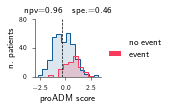

In [30]:
magnification = 0.85
ratio = 2.4/3.7
CF.SetPlotParams(magnification=magnification, ratio=ratio, 
                        fontsize=fontsize, ylabelsize=ylabelsize, xlabelsize=xlabelsize, 
                        tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.bottom'] = True
mec = 'white'
ms = 9
mew = 0.15


fig, ax = plt.subplots()

y_target = y_train
th = CL.best_threshold_class0(y_pred=y_pred, value_pred=value_pred, y_target=y_train, min_NPV=0.96, fixed_threshold=False)
y_pred = np.zeros_like(y_target)
y_pred[value_pred>=th] = 1
y_pred_1 = 1 - y_pred
y_target_1 = 1 - y_target
npv_model = precision_score(y_target_1, y_pred_1)
spe_model = recall_score(y_target_1, y_pred_1)
print('NPV: %.2f'%npv_model, '\nSpec.: %.2f'%spe_model)

x_min = min([np.nanmin(x0), np.nanmin(x1), np.nanmin(x_test)])
x_max = max([np.nanmax(x0), np.nanmax(x1), np.nanmax(x_test)])
if model_name in immunecells_set:
    x_control = x_test
    print('control: %d' % (round(100*np.sum(x_control<th)/len(x_control))))

bins = np.linspace(x_min-0.2, x_max+0.2, 14)

color = color_0
density = False
ax.hist(x0, bins,
        alpha=0.15,
        histtype='stepfilled',
        color=color,
        density=density)
ax.hist(x0, bins,
        alpha=1., 
        histtype='step',
        edgecolor=color,
        density=density,
        facecolor='None', 
        label='no event')

bins = np.linspace(x_min-0.2, x_max+0.2, 13)

if model_name in immunecells_set:
    color = color_control
    ax.hist(x_control, bins,
            alpha=0.2,
            histtype='stepfilled',
            color=color,
            density=density,
            label='control')
    ax.hist(x_control, bins,
            alpha=1.,
            histtype='step',
            edgecolor=color,
            density=density,
            facecolor='None')

color = color_1
ax.hist(x1, bins,
        alpha=0.2,
        histtype='stepfilled',
        color=color,
        density=density,
        label='event')
ax.hist(x1, bins,
        alpha=1., 
        histtype='step',
        edgecolor=color,
        density=density,
        facecolor='None')

color_boundary = CF.lighten_color(grey_1, 0.6)
#ax.axvline(th, ls='-', lw=0.9, color=electricblue)
ax.axvline(th, ls='--', lw=0.7, color='black') 

ax.title.set_text('npv=%.2f $\,\,\,$ spe.=%.2f'%(npv_model, spe_model))
ax.set_xlabel('%s score' % (CF.change_names_2([model_name])[0]))
ax.set_ylabel('n. patients')
if density:
    ax.set_ylabel('patients (density)')

if model_name=='LRTE/uL':
        ax.set_yticks([0., 45., 90])
        ax.set_ylim([0, 90])
if model_name=='PROADM':
        ax.set_yticks([0., 40., 80.])
        ax.set_ylim([0, 80])
if model_name=='IP10':
        ax.set_yticks([0., 20., 40.])
        ax.set_ylim([0, 40])

leg = ax.legend(loc='center left', bbox_to_anchor=(0.98, 0.5), frameon=False) #legend(loc=0, frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_edgecolor('white')

filename = 'HistogramLR#%s' % (CF.change_names_2([model_name])[0])
filename = filename + exp_description + exp_univ_description + '.pdf'
saving_str = path_figures + filename
plt.savefig(saving_str, bbox_inches='tight')